# Step 1: Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# Load the dataset
df = pd.read_csv("customer_booking.csv", encoding='latin1')

# Preview
print(df.head())
print(df.info())


   num_passengers sales_channel  trip_type  purchase_lead  length_of_stay  \
0               2      Internet  RoundTrip            262              19   
1               1      Internet  RoundTrip            112              20   
2               2      Internet  RoundTrip            243              22   
3               1      Internet  RoundTrip             96              31   
4               2      Internet  RoundTrip             68              22   

   flight_hour flight_day   route booking_origin  wants_extra_baggage  \
0            7        Sat  AKLDEL    New Zealand                    1   
1            3        Sat  AKLDEL    New Zealand                    0   
2           17        Wed  AKLDEL          India                    1   
3            4        Sat  AKLDEL    New Zealand                    0   
4           15        Wed  AKLDEL          India                    1   

   wants_preferred_seat  wants_in_flight_meals  flight_duration  \
0                     0        

# Step 2: Data Preprocessing

In [2]:
# Define features and target
X = df.drop("booking_complete", axis=1)
y = df["booking_complete"]

# Identify categorical & numeric columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(exclude=['object']).columns.tolist()

# One-hot encode categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'  # keep numeric columns as they are
)


# Step 3: Handle Class Imbalance

In [3]:
# Compute class weights (optional, for reference)
classes = np.unique(y)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weights_dict = dict(zip(classes, weights))
print("Class Weights:", class_weights_dict)


Class Weights: {np.int64(0): np.float64(0.587930953388834), np.int64(1): np.float64(3.3431398769724527)}


# Step 4: Build Random Forest Pipeline

In [4]:
# Build RandomForest pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        class_weight='balanced'
    ))
])

# Step 5: Train-Test Split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# Step 6: Train the Model

In [6]:
model.fit(X_train, y_train)

C:\Users\ninos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['sales_channel', 'trip_type',
                                                   'flight_day', 'route',
                                                   'booking_origin'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=200, random_state=42))])

# Step 7: Model Evaluation

In [7]:
# Predictions
y_pred = model.predict(X_test)

# Metrics
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Cross-validation score
cv_scores = cross_val_score(model, X, y, cv=5, scoring='f1')
print("Cross-Validation F1 Scores:", cv_scores)
print("Average F1 Score:", np.mean(cv_scores))


              precision    recall  f1-score   support

           0       0.86      0.98      0.92      8504
           1       0.51      0.10      0.17      1496

    accuracy                           0.85     10000
   macro avg       0.69      0.54      0.54     10000
weighted avg       0.81      0.85      0.81     10000

Confusion Matrix:
 [[8358  146]
 [1343  153]]
Cross-Validation F1 Scores: [0.01575837 0.11917563 0.         0.00859923 0.304     ]
Average F1 Score: 0.08950664589404633


# Step 8: Feature Importance

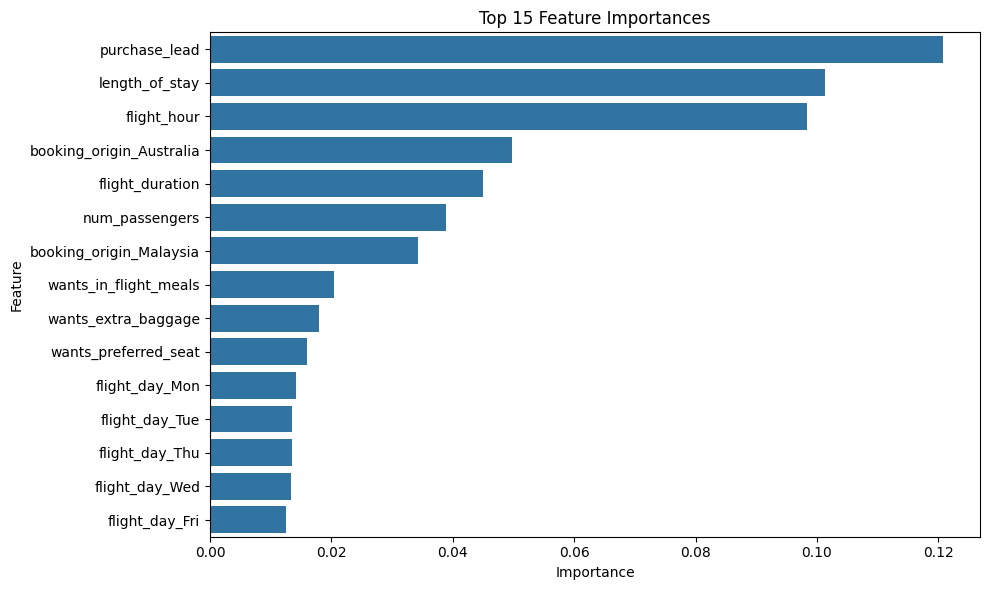

In [8]:
# Get feature names after encoding
feature_names = model.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(categorical_cols)
feature_names = np.append(feature_names, numeric_cols)

# Get importances
importances = model.named_steps['classifier'].feature_importances_
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
plt.title("Top 15 Feature Importances")
plt.tight_layout()
plt.show()